In [1]:
%matplotlib notebook

# Iris/dask dataset loading investigation

## Introduction

This demos using dask functionality beyond the `array` module to help with Iris processing. Specifically, in this notebook we will demo alternative approaches for loading numerous and/or large datasets into Iris.

Three approaches will be compared:

* The standard Iris load
* ~~Wrapping Iris load calls in a **dask bag** generated from a sequence (this is slow so will not be investigated further)~~
* Wrapping Iris load calls in a **dask bag** generated from a **delayed** call

These options will be compared with two simple metrics:

- Ease of use
- Runtime

## Setup

Below are the functions used to load the dataset. There is one function for each of the standard Iris load and the bag generated from a sequence. The bag generated from a delayed call requires two functions; one which is delayed, one to call the delayed function.

### Imports

In [2]:
import os
import time

import dask.bag as db
import dask.delayed as delayed
import iris

In [3]:
print iris

<module 'iris' from '/home/h04/dkillick/git/iris/lib/iris/__init__.pyc'>


### Timer function

A simple function that records the runtime of a supplied function. This will be useful for capturing results; otherwise within this notebook we can just make use of the `%timeit` magic. 

In [4]:
def timer(func, *funcargs):
    t0 = time.time()
    func(*funcargs)
    t1 = time.time()
    return t1 - t0

def repeater(repeat, *timerargs):
    if repeat <= 1:
        result = timer(*timerargs)
    else:
        result = [timer(*timerargs) for _ in range(repeat)]
    return result

### Runner functions

In [5]:
def direct_load(fp, pattern):
    """Load datasets at the filepath `fp` using Iris."""
    iris.load(os.path.join(fp, pattern))

def delay_wrapper(fp, pattern):
    dlyd = delayed(iris.load)(fp, pattern))
    cs = db.from_delayed(dlyd)
    iris.cube.CubeList(cs.compute(get=dask.multiprocessing.get))

## Test!

Run each loader on some sample data and print the output.

Using **sample PP data** at `/project/euro4_hindcast/WIND-ATLAS_EURO4-RERUN/2015/06/18Z`:

In [15]:
fp = '/project/euro4_hindcast/WIND-ATLAS_EURO4-RERUN/2015/06/18Z'
fn = 'EURO4_2015060[1-3].pp'
seq = os.listdir(fp)
reps = 3

In [17]:
direct_load_vals_pp = repeater(reps, direct_load, fp, fn)
# with_bag_vals_pp = repeater(reps, withbag, fp, seq)
delay_vals_v2_pp = repeater(reps, delay_wrapper_v2, fp, fn)

<IPython.core.display.Javascript object>


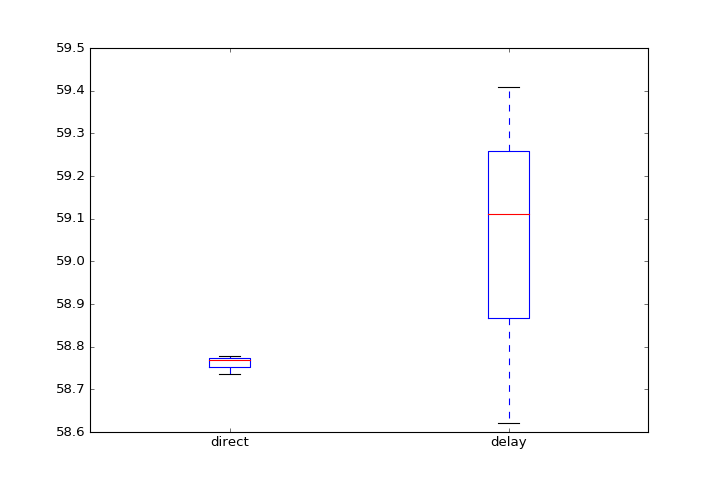

In [18]:
fig = plt.figure(figsize=(9, 6))
plt.boxplot([direct_load_vals_pp, delay_vals_v2_pp],
            vert=True, labels=['direct', 'delay'])
plt.show()